## Download specific versions and source code locally

It would be enough for experimenting. If you want to stick strictly to all versions, use requirements.txt in the repository

In [ ]:
# torch==1.10
!pip install transformers==4.16.2 datasets==1.17.0 tokenizers==0.11.6 wandb==0.12.14 seqeval

     |████████████████████████████████| 3.5 MB 26.4 MB/s 
     |████████████████████████████████| 306 kB 68.7 MB/s 
     |████████████████████████████████| 6.5 MB 32.6 MB/s 
     |████████████████████████████████| 1.8 MB 61.4 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 77 kB 8.1 MB/s 
     |████████████████████████████████| 596 kB 59.4 MB/s 
     |████████████████████████████████| 895 kB 65.2 MB/s 
     |████████████████████████████████| 212 kB 61.1 MB/s 
     |████████████████████████████████| 1.1 MB 65.3 MB/s 
     |████████████████████████████████| 136 kB 79.4 MB/s 
     |████████████████████████████████| 144 kB 53.2 MB/s 
     |████████████████████████████████| 181 kB 67.5 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 271 kB 71.3 MB/s 
     |████████████████████████████████| 144 kB 71.9 MB/s 
     |████████████████████████████████| 94 kB 4.5 MB/s 
  Created wheel for se

In [1]:
!nvidia-smi

Wed Apr 20 05:08:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
%cd /content
!rm -r ntu_nlp_al
!git clone -b release https://github.com/DevKretov/ntu_nlp_al

/content
rm: cannot remove 'ntu_nlp_al': No such file or directory
Cloning into 'ntu_nlp_al'...
remote: Enumerating objects: 228, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 228 (delta 133), reused 158 (delta 69), pack-reused 0
Receiving objects: 100% (228/228), 56.85 MiB | 17.47 MiB/s, done.
Resolving deltas: 100% (133/133), done.
Checking out files: 100% (39/39), done.


In [2]:
%cd ntu_nlp_al/

/content/ntu_nlp_al


If you want to install all packages in correspondence with what we have locally, use it

In [5]:
#!pip install -r requirements.txt

     |████████████████████████████████| 306 kB 12.2 MB/s 
     |████████████████████████████████| 11.2 MB 48.3 MB/s 
     |████████████████████████████████| 15.7 MB 44.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 6.5 MB 41.9 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.3 MB/s eta 0:00:36tcmalloc: large alloc 1147494400 bytes == 0x55cc7e22e000 @  0x7fb5949dc615 0x55cc19a2717c 0x55cc19b0747a 0x55cc19a29f9d 0x55cc19b1bd4d 0x55cc19a9dec8 0x55cc19a98a2e 0x55cc19a2b88a 0x55cc19a9dd30 0x55cc19a98a2e 0x55cc19a2b88a 0x55cc19a9a719 0x55cc19b1cb76 0x55cc19a99d95 0x55cc19b1cb76 0x55cc19a99d95 0x55cc19b1cb76 0x55cc19a99d95 0x55cc19a2bce9 0x55cc19a6f579 0x55cc19a2a902 0x55cc19a9dc4d 0x55cc19a98a2e 0x55cc19a2b88a 0x55cc19a9a719 0x55cc19a98a2e 0x55cc19a2b88a 0x55cc19a998f6 0x55cc19a2b7aa 0x55cc19a99b4f 0x55cc19a98a2e
     |████████████████████████████████| 881.9 MB 2.0 kB/s 

## Initialisation

In [3]:
import logging

import torch
from transformers import get_scheduler
from datasets import list_metrics, load_metric

from active_learning_trainer import ALTrainer
from transformers import AutoTokenizer
from dataset import ClassificationDataset, TokenClassificationDataset
from utils import TrainingVisualisation
from model import Model
import pandas as pd

import datetime
import wandb
from pathlib import Path
import json
import yaml

LOCAL_RUNS_FOLDER = 'runs'
LOCAL_RUNS_FOLDER_PATH = Path(LOCAL_RUNS_FOLDER)

TRASK = True


In [4]:
CONFIGS_FOLDER_NAME = 'configs'
APP_CONFIG_FILE_NAME = 'config.yaml'
CONFIGS_FOLDER_PATH = Path('__file__').resolve().parent / CONFIGS_FOLDER_NAME
APP_CONFIG_FILE_NAME = CONFIGS_FOLDER_PATH / APP_CONFIG_FILE_NAME

config = yaml.safe_load(open(str(APP_CONFIG_FILE_NAME)))

dataset_config = yaml.safe_load(
    open(
        CONFIGS_FOLDER_PATH / (config['run']['selected_dataset'] + '.yaml')
    )
)

current_timestamp = str(datetime.datetime.now()).split('.')[0]

## Configuration of the run

In [5]:
config['run']['strategies'] = ['random',]
config['run']['pretrained_model_name'] = 'prajjwal1/bert-tiny'
config['run']['finetuned_model_type'] = 'classification'
config['run']['class_imbalance_reweight'] = False
config['run']['run'] = False
config['app']['debug_mode'] = True
config['run']['selected_dataset'] = 'tweets_classification'
config['run']['weights_and_biases_on'] = True

config['run']['visualise_locally'] = True
config['run']['full_train'] = True

In [6]:
device = 'cpu'
if config['model']['use_gpu']:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

weights_and_biases_run_name = f'''{current_timestamp}_run_{config['run']['finetuned_model_type']}_{device}'''
if config['app']['debug_mode']:
    weights_and_biases_run_name = 'DEBUG_' + weights_and_biases_run_name

logging.info(f'Device set to {device}!')

2022-04-20 06:55:26,732 root INFO:Device set to cuda:0!


## Preparing tokenizer, dataset, model

In [7]:
tokenizer = AutoTokenizer.from_pretrained(
    config['run']['pretrained_model_name']
)

dataset_obj = None
if config['run']['finetuned_model_type'] == config['app']['model_classification_name']:
    dataset_obj = ClassificationDataset(tokenizer)
elif config['run']['finetuned_model_type'] == config['app']['model_tagging_name']:
    dataset_obj = TokenClassificationDataset(tokenizer)
else:
    raise NotImplementedError(f'''Type {config['run']['finetuned_model_type']} not supported yet!''')

if dataset_config['load_from_hub']:
    dataset_name = dataset_config['hub_dataset_name']
    #dataset_name = parameters['dataset_from_datasets_hub_name']
    dataset_obj.load_hosted_dataset(dataset_name)
else:
    data_files = {
        config['app']['dataset_train_key']: [dataset_config['train_file_path']],
        config['app']['dataset_val_key']: [dataset_config['val_file_path']],
        config['app']['dataset_test_key']: [dataset_config['test_file_path']]
    }

    dataset_obj.load_csv_dataset(
        data_files,
        delimiter=dataset_config['delimiter']
    )

dataset_obj.truncate_dataset(
    config['app']['dataset_train_key'],
    config['dataset']['train_dataset_size'],
    shuffle=config['dataset']['shuffle_datasets']
)
dataset_obj.truncate_dataset(
    config['app']['dataset_val_key'],
    config['dataset']['val_dataset_size'],
    shuffle=config['dataset']['shuffle_datasets']
)
dataset_obj.truncate_dataset(
    config['app']['dataset_test_key'],
    config['dataset']['val_dataset_size'],
    shuffle=config['dataset']['shuffle_datasets']
)

dataset_obj.prepare_dataset(
    dataset_config['label_column_name'],
    dataset_config['text_column_name'],
)

2022-04-20 06:55:30,827 datasets.builder WARNING:Using custom data configuration default-84e6dc25b67b0fc5
2022-04-20 06:55:30,834 datasets.builder WARNING:Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-84e6dc25b67b0fc5/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e)


  0%|          | 0/3 [00:00<?, ?it/s]

Flattening the indices:   0%|          | 0/10 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/10 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10000 [00:00<?, ?ex/s]

  0%|          | 0/1000 [00:00<?, ?ex/s]

  0%|          | 0/1000 [00:00<?, ?ex/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [8]:
### Prepare W&B structure for saving predictions
wandb_table = None
if config['run']['weights_and_biases_on'] and \
    config['reporting']['weights_and_biases_save_predictions']:

    categories = sorted(list(dataset_obj.get_all_categories().items()), key=lambda key: key[1])
    categories_names = [_tuple[0] for _tuple in categories]
    wandb_table_columns = config['reporting']['weights_and_biases_eval_table_columns'] + categories_names
    wandb_table = wandb.Table(columns=wandb_table_columns)

logging.info(f'Categories: {dataset_obj.get_all_categories()}')
num_labels = dataset_obj.get_num_categories()


2022-04-20 06:55:49,067 root INFO:Categories: {'alt': 0, 'comp': 1, 'misc': 2, 'rec': 3, 'sci': 4, 'soc': 5, 'talk': 6}


In [9]:
model = Model(
    config['run']['pretrained_model_name'],
    model_type=config['run']['finetuned_model_type'],
    num_labels=num_labels
)

run = None

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

### Connect to W&B environment

In [10]:
this_run_folder_path = LOCAL_RUNS_FOLDER_PATH / weights_and_biases_run_name
this_run_folder_path.mkdir(exist_ok=True, parents=True)

if config['run']['weights_and_biases_on']:
    wandb.login(key=config['reporting']['weights_and_biases_key'])
    run = wandb.init(
        name=weights_and_biases_run_name,
        project=config['reporting']['project_name'],
        reinit=True
    )

    wandb.config.update(config)
    wandb.config.update(dataset_config)

    wandb.watch(model.model)
    artifact = wandb.Artifact(
        config['reporting']['init_dataset_artifact_name'],
        type='dataset'
    )

    for _dataset in dataset_obj.dataset.keys():
        save_path = str(this_run_folder_path / (_dataset + '_dataset.csv'))
        dataset_df = pd.DataFrame.from_dict(
            dataset_obj.dataset[_dataset].to_dict(32)
        ).to_csv(save_path, index=False)

        artifact.add_file(save_path)

    run.log_artifact(artifact)

wandb: Currently logged in as: trask (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Init trainer and combine everything

In [11]:
trainer = ALTrainer(
    wandb_on=config['run']['weights_and_biases_on'],
    imbalanced_training=config['run']['class_imbalance_reweight'],
    model_type=config['run']['finetuned_model_type'],
    wandb_run=run,
    wandb_table=wandb_table,
    wandb_save_datasets_artifacts=config['reporting']['weights_and_biases_save_dataset_artifacts']
)
trainer.set_model(model)

# TODO: add strategy
trainer.set_strategy(None)
trainer.set_dataset(dataset_obj)
dataset_obj.prepare_dataloaders(
    train_batch_size=config['model']['train_batch_size'],
    val_batch_size=config['model']['val_batch_size'],
    test_batch_size=config['model']['test_batch_size'],
)

optimizer = torch.optim.AdamW(
    model.model.parameters(),
    lr=config['model']['learning_rate']
)
trainer.set_optimizer(optimizer)

num_training_steps = config['model']['train_epochs'] * trainer.get_training_steps_num()

# TODO: Implement LR scheduler or decide if it is needed or not (basing on the way how BERT models are fine-tuned (max 5 epochs)
# lr_scheduler = get_scheduler(
#     name="linear",
#     optimizer=optimizer,
#     num_warmup_steps=0,
#     num_training_steps=num_training_steps
# )
# trainer.set_lr_scheduler(lr_scheduler)
trainer.set_device(device)

trainer.add_evaluation_metric(load_metric('accuracy'))

metrics_list = []
if config['run']['finetuned_model_type'] == config['app']['model_tagging_name']:
    metrics_list = config['model']['metrics']['tagging']
elif config['run']['finetuned_model_type'] == config['app']['model_classification_name']:
    metrics_list = config['model']['metrics']['classification']
else:
    raise NotImplementedError(f'''There is no such model type implemented like {config['run']['finetuned_model_type']}''')

for metric in metrics_list:
    trainer.add_evaluation_metric(load_metric(metric))


## Train

2022-04-20 07:01:56,686 root INFO:Full training initialized!
2022-04-20 07:01:56,688 root INFO:Training is run on 313 batches!
2022-04-20 07:01:56,693 root INFO:Evaluation is run on 16 batches!
2022-04-20 07:01:56,696 root INFO:Testing is run on 16 batches!
2022-04-20 07:01:56,700 root INFO:

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NO

Training mean loss: 1.9039560317993165:   2%|▏         | 5/313 [00:00<00:32,  9.51it/s]

2022-04-20 07:01:58,068 root INFO:Epoch finished. Evaluation:
2022-04-20 07:01:58,072 root INFO:

Epoch   2


Training mean loss: 1.8740703821182252:   1%|▏         | 4/313 [00:00<00:28, 10.67it/s]

2022-04-20 07:01:58,550 root INFO:Epoch finished. Evaluation:
2022-04-20 07:01:58,554 root INFO:

Epoch   3


Training mean loss: 1.857472825050354:   1%|▏         | 4/313 [00:00<00:27, 11.13it/s] 

2022-04-20 07:01:59,022 root INFO:Epoch finished. Evaluation:
2022-04-20 07:01:59,026 root INFO:

Epoch   4


Training mean loss: 1.8098981618881225:   1%|▏         | 4/313 [00:00<00:30,  9.99it/s]

2022-04-20 07:01:59,527 root INFO:Epoch finished. Evaluation:
2022-04-20 07:01:59,531 root INFO:

Epoch   5


Training mean loss: 1.8041876077651977:   1%|▏         | 4/313 [00:00<00:27, 11.04it/s]

2022-04-20 07:01:59,994 root INFO:Epoch finished. Evaluation:
2022-04-20 07:01:59,998 root INFO:Running Eval mode...


Eval mean loss: 1.7828513860702515: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

2022-04-20 07:02:01,711 root INFO:Test set evaluation:
2022-04-20 07:02:01,718 root INFO:Running Test mode...



Test mean loss: 1.7824292108416557:  94%|█████████▍| 15/16 [00:03<00:00,  5.21it/s]

2022-04-20 07:02:05,021 root INFO:
Metrics, confusion matrix
2022-04-20 07:02:05,037 root INFO:
[[  0  31   0   0   0   0  19]
 [  0 260   0   0   0   0   1]
 [  0  45   0   0   0   0   0]
 [  0 183   0  34   0   0   2]
 [  0 184   0   1   0   0   8]
 [  0  35   0   1   0   0  27]
 [  0  89   0   5   0   0  75]]
2022-04-20 07:02:05,046 root INFO:{'conf_mat': <wandb.viz.CustomChart object at 0x7fd138c41910>, 'accuracy': 0.369}
2022-04-20 07:02:05,058 root INFO:{'conf_mat': <wandb.viz.CustomChart object at 0x7fd138c41910>, 'accuracy': 0.369, 'f1': 0.41022933626923985}
2022-04-20 07:02:05,069 root INFO:{'conf_mat': <wandb.viz.CustomChart object at 0x7fd138c41910>, 'accuracy': 0.369, 'f1': 0.41022933626923985, 'precision': 0.5542189616379928}
2022-04-20 07:02:05,087 root INFO:{'conf_mat': <wandb.viz.CustomChart object at 0x7fd138c41910>, 'accuracy': 0.369, 'f1': 0.41022933626923985, 'precision': 0.5542189616379928, 'recall': 0.5685670261941448}
2022-04-20 07:02:05,096 root INFO:{'conf_mat'


Training mean loss: 1.8041876077651977:   2%|▏         | 5/313 [00:06<06:29,  1.27s/it]

2022-04-20 07:02:05,871 root INFO:
Full training finished
2022-04-20 07:02:05,882 root INFO:Training initialized!


  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

2022-04-20 07:02:17,179 root INFO:

2022-04-20 07:02:17,181 root INFO:AL Random strategy applied!
2022-04-20 07:02:17,184 root INFO:
2022-04-20 07:02:17,186 root INFO:
AL iteration   1/5
2022-04-20 07:02:17,189 root INFO:Training is run on 1 batches!
2022-04-20 07:02:17,192 root INFO:Evaluation is run on 16 batches!
2022-04-20 07:02:17,195 root INFO:Testing is run on 16 batches!
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializ

Training mean loss: 2.036741256713867: 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]

2022-04-20 07:02:18,164 root INFO:Epoch finished. Evaluation:
2022-04-20 07:02:18,168 root INFO:

Epoch   2


Training mean loss: 2.0036208629608154: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

2022-04-20 07:02:18,291 root INFO:Epoch finished. Evaluation:
2022-04-20 07:02:18,294 root INFO:

Epoch   3


Training mean loss: 1.9657377004623413: 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

2022-04-20 07:02:18,419 root INFO:Epoch finished. Evaluation:
2022-04-20 07:02:18,422 root INFO:

Epoch   4


Training mean loss: 1.9801424741744995: 100%|██████████| 1/1 [00:00<00:00,  9.57it/s]

2022-04-20 07:02:18,542 root INFO:Epoch finished. Evaluation:
2022-04-20 07:02:18,545 root INFO:

Epoch   5


Training mean loss: 1.945343255996704: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

2022-04-20 07:02:18,668 root INFO:Epoch finished. Evaluation:
2022-04-20 07:02:18,671 root INFO:Running Eval mode...


Eval mean loss: 1.9307311058044434: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

2022-04-20 07:02:20,512 root INFO:Previous best f1 score = 0, now = 0.09407160386539375. Best model saved!



Eval mean loss: 1.9307311058044434: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]

2022-04-20 07:02:20,522 root INFO:Test set evaluation:
2022-04-20 07:02:20,526 root INFO:Running Test mode...



Test mean loss: 1.9415636658668518:  94%|█████████▍| 15/16 [00:03<00:00,  5.11it/s]

2022-04-20 07:02:23,900 root INFO:
Metrics, confusion matrix
2022-04-20 07:02:23,918 root INFO:
[[  0  29  12   1   6   1   1]
 [  0  31 152   5  53  20   0]
 [  0   5  25   0  12   3   0]
 [  0  61 122   7  27   2   0]
 [  0  40 102   4  41   6   0]
 [  0  41  12   0   8   2   0]
 [  0  87  46   3  25   8   0]]
2022-04-20 07:02:23,927 root INFO:{'conf_mat': <wandb.viz.CustomChart object at 0x7fd138c9fd10>, 'accuracy': 0.106}
2022-04-20 07:02:23,938 root INFO:{'conf_mat': <wandb.viz.CustomChart object at 0x7fd138c9fd10>, 'accuracy': 0.106, 'f1': 0.09695218722681061}
2022-04-20 07:02:23,952 root INFO:{'conf_mat': <wandb.viz.CustomChart object at 0x7fd138c9fd10>, 'accuracy': 0.106, 'f1': 0.09695218722681061, 'precision': 0.16375237594589556}
2022-04-20 07:02:23,963 root INFO:{'conf_mat': <wandb.viz.CustomChart object at 0x7fd138c9fd10>, 'accuracy': 0.106, 'f1': 0.09695218722681061, 'precision': 0.16375237594589556, 'recall': 0.11157894736842106}
2022-04-20 07:02:23,972 root INFO:{'conf_m


Training mean loss: 1.945343255996704: 100%|██████████| 1/1 [00:06<00:00,  6.29s/it]

2022-04-20 07:02:24,850 root INFO:Selecting 32 indices from 9968 


  0%|          | 0/10 [00:00<?, ?ba/s]

2022-04-20 07:02:30,200 root INFO:
2022-04-20 07:02:30,205 root INFO:
AL iteration   2/5
2022-04-20 07:02:30,206 root INFO:Training is run on 2 batches!
2022-04-20 07:02:30,208 root INFO:Evaluation is run on 16 batches!
2022-04-20 07:02:30,211 root INFO:Testing is run on 16 batches!
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected

Training mean loss: 1.9318268299102783: 100%|██████████| 2/2 [00:00<00:00,  9.46it/s]

2022-04-20 07:02:31,278 root INFO:Epoch finished. Evaluation:
2022-04-20 07:02:31,287 root INFO:

Epoch   2


Training mean loss: 1.919994294643402:  50%|█████     | 1/2 [00:00<00:00,  9.96it/s] 

2022-04-20 07:02:31,492 root INFO:Epoch finished. Evaluation:
2022-04-20 07:02:31,496 root INFO:

Epoch   3


Training mean loss: 1.8874953985214233: 100%|██████████| 2/2 [00:00<00:00, 10.08it/s]

2022-04-20 07:02:31,709 root INFO:Epoch finished. Evaluation:
2022-04-20 07:02:31,710 root INFO:

Epoch   4


Training mean loss: 1.869156539440155: 100%|██████████| 2/2 [00:00<00:00, 10.32it/s]

2022-04-20 07:02:31,920 root INFO:Epoch finished. Evaluation:
2022-04-20 07:02:31,924 root INFO:

Epoch   5


Training mean loss: 1.8456037640571594: 100%|██████████| 2/2 [00:00<00:00, 10.49it/s]

2022-04-20 07:02:32,125 root INFO:Epoch finished. Evaluation:
2022-04-20 07:02:32,128 root INFO:Running Eval mode...


Eval mean loss: 1.8639550924301147: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

2022-04-20 07:02:33,910 root INFO:Previous best f1 score = 0.09407160386539375, now = 0.1411248102325492. Best model saved!



Eval mean loss: 1.8639550924301147: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]

2022-04-20 07:02:33,925 root INFO:Test set evaluation:
2022-04-20 07:02:33,935 root INFO:Running Test mode...



Test mean loss: 1.870140753686428:  94%|█████████▍| 15/16 [00:03<00:00,  5.43it/s] 

2022-04-20 07:02:37,112 root INFO:
Metrics, confusion matrix
2022-04-20 07:02:37,133 root INFO:
[[  0  50   0   0   0   0   0]
 [  0 261   0   0   0   0   0]
 [  0  45   0   0   0   0   0]
 [  0 216   0   0   3   0   0]
 [  0 192   0   0   1   0   0]
 [  0  62   0   0   0   0   1]
 [  3 160   0   0   0   0   6]]
2022-04-20 07:02:37,144 root INFO:{'conf_mat': <wandb.viz.CustomChart object at 0x7fd13882a510>, 'accuracy': 0.268}
2022-04-20 07:02:37,161 root INFO:{'conf_mat': <wandb.viz.CustomChart object at 0x7fd13882a510>, 'accuracy': 0.268, 'f1': 0.18237434188582438}
2022-04-20 07:02:37,172 root INFO:{'conf_mat': <wandb.viz.CustomChart object at 0x7fd13882a510>, 'accuracy': 0.268, 'f1': 0.18237434188582438, 'precision': 0.38959194376115974}
2022-04-20 07:02:37,183 root INFO:{'conf_mat': <wandb.viz.CustomChart object at 0x7fd13882a510>, 'accuracy': 0.268, 'f1': 0.18237434188582438, 'precision': 0.38959194376115974, 'recall': 0.39821693907875183}
2022-04-20 07:02:37,192 root INFO:{'conf_m


Training mean loss: 1.8456037640571594: 100%|██████████| 2/2 [00:06<00:00,  3.00s/it]

2022-04-20 07:02:37,938 root INFO:Selecting 32 indices from 9936 


  0%|          | 0/10 [00:00<?, ?ba/s]

2022-04-20 07:02:43,775 root INFO:
2022-04-20 07:02:43,778 root INFO:
AL iteration   3/5
2022-04-20 07:02:43,780 root INFO:Training is run on 3 batches!
2022-04-20 07:02:43,789 root INFO:Evaluation is run on 16 batches!
2022-04-20 07:02:43,791 root INFO:Testing is run on 16 batches!
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected

Training mean loss: 1.89522389570872:  67%|██████▋   | 2/3 [00:00<00:00, 11.10it/s] 

2022-04-20 07:02:44,907 root INFO:Epoch finished. Evaluation:
2022-04-20 07:02:44,913 root INFO:

Epoch   2


Training mean loss: 1.869908372561137: 100%|██████████| 3/3 [00:00<00:00,  9.65it/s]

2022-04-20 07:02:45,241 root INFO:Epoch finished. Evaluation:
2022-04-20 07:02:45,244 root INFO:

Epoch   3


Training mean loss: 1.8197755813598633:  67%|██████▋   | 2/3 [00:00<00:00, 11.03it/s]

2022-04-20 07:02:45,525 root INFO:Epoch finished. Evaluation:
2022-04-20 07:02:45,531 root INFO:

Epoch   4


Training mean loss: 1.806859811147054:  67%|██████▋   | 2/3 [00:00<00:00, 11.13it/s] 

2022-04-20 07:02:45,813 root INFO:Epoch finished. Evaluation:
2022-04-20 07:02:45,817 root INFO:

Epoch   5


Training mean loss: 1.7803369760513306:  67%|██████▋   | 2/3 [00:00<00:00, 11.03it/s]

2022-04-20 07:02:46,097 root INFO:Epoch finished. Evaluation:
2022-04-20 07:02:46,099 root INFO:Running Eval mode...


Eval mean loss: 1.7944614171981812: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

2022-04-20 07:02:47,901 root INFO:Previous best f1 score = 0.1411248102325492, now = 0.38166539785152187. Best model saved!



Eval mean loss: 1.7944614171981812: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]

2022-04-20 07:02:47,912 root INFO:Test set evaluation:
2022-04-20 07:02:47,914 root INFO:Running Test mode...



Test mean loss: 1.7980766743421555:  94%|█████████▍| 15/16 [00:03<00:00,  5.37it/s]

2022-04-20 07:02:51,150 root INFO:
Metrics, confusion matrix
2022-04-20 07:02:51,165 root INFO:
[[  0   5   0  11  34   0   0]
 [  0 102   0 138  21   0   0]
 [  0  16   0  25   4   0   0]
 [  0  34   0 178   7   0   0]
 [  0  29   0  67  97   0   0]
 [  0   4   0  10  49   0   0]
 [  0  11   0  54 100   0   4]]
2022-04-20 07:02:51,176 root INFO:{'conf_mat': <wandb.viz.CustomChart object at 0x7fd138d65490>, 'accuracy': 0.381}
2022-04-20 07:02:51,187 root INFO:{'conf_mat': <wandb.viz.CustomChart object at 0x7fd138d65490>, 'accuracy': 0.381, 'f1': 0.3661094839260595}
2022-04-20 07:02:51,198 root INFO:{'conf_mat': <wandb.viz.CustomChart object at 0x7fd138d65490>, 'accuracy': 0.381, 'f1': 0.3661094839260595, 'precision': 0.5251295022047464}
2022-04-20 07:02:51,208 root INFO:{'conf_mat': <wandb.viz.CustomChart object at 0x7fd138d65490>, 'accuracy': 0.381, 'f1': 0.3661094839260595, 'precision': 0.5251295022047464, 'recall': 0.4524940617577197}
2022-04-20 07:02:51,217 root INFO:{'conf_mat': <


Training mean loss: 1.7803369760513306: 100%|██████████| 3/3 [00:06<00:00,  2.04s/it]

2022-04-20 07:02:51,956 root INFO:Selecting 32 indices from 9904 


  0%|          | 0/10 [00:00<?, ?ba/s]

2022-04-20 07:02:57,721 root INFO:
2022-04-20 07:02:57,724 root INFO:
AL iteration   4/5
2022-04-20 07:02:57,727 root INFO:Training is run on 4 batches!
2022-04-20 07:02:57,729 root INFO:Evaluation is run on 16 batches!
2022-04-20 07:02:57,731 root INFO:Testing is run on 16 batches!
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected

Training mean loss: 1.973548024892807: 100%|██████████| 4/4 [00:00<00:00,  9.08it/s]

2022-04-20 07:02:59,027 root INFO:Epoch finished. Evaluation:
2022-04-20 07:02:59,032 root INFO:

Epoch   2


Training mean loss: 1.9211657643318176: 100%|██████████| 4/4 [00:00<00:00,  9.67it/s]

2022-04-20 07:02:59,460 root INFO:Epoch finished. Evaluation:
2022-04-20 07:02:59,463 root INFO:

Epoch   3


Training mean loss: 1.8836313486099243:  75%|███████▌  | 3/4 [00:00<00:00, 10.27it/s]

2022-04-20 07:02:59,864 root INFO:Epoch finished. Evaluation:
2022-04-20 07:02:59,866 root INFO:

Epoch   4


Training mean loss: 1.8528632819652557:  75%|███████▌  | 3/4 [00:00<00:00,  9.66it/s]

2022-04-20 07:03:00,280 root INFO:Epoch finished. Evaluation:
2022-04-20 07:03:00,286 root INFO:

Epoch   5


Training mean loss: 1.8035349249839783: 100%|██████████| 4/4 [00:00<00:00, 10.40it/s]

2022-04-20 07:03:00,684 root INFO:Epoch finished. Evaluation:
2022-04-20 07:03:00,685 root INFO:Running Eval mode...


Eval mean loss: 1.8367640733718873: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

2022-04-20 07:03:02,439 root INFO:Test set evaluation:
2022-04-20 07:03:02,448 root INFO:Running Test mode...



Test mean loss: 1.824945330619812:  94%|█████████▍| 15/16 [00:03<00:00,  5.31it/s] 

2022-04-20 07:03:05,675 root INFO:
Metrics, confusion matrix
2022-04-20 07:03:05,700 root INFO:
[[  0  48   0   0   0   0   2]
 [  0 253   0   0   2   0   6]
 [  0  43   0   1   0   0   1]
 [  0 160   0  30   9   0  20]
 [  0 166   0   0  17   0  10]
 [  0  62   0   0   1   0   0]
 [  0 134   0   0  26   0   9]]
2022-04-20 07:03:05,710 root INFO:{'conf_mat': <wandb.viz.CustomChart object at 0x7fd13e15fed0>, 'accuracy': 0.309}
2022-04-20 07:03:05,722 root INFO:{'conf_mat': <wandb.viz.CustomChart object at 0x7fd13e15fed0>, 'accuracy': 0.309, 'f1': 0.24966957727846328}
2022-04-20 07:03:05,734 root INFO:{'conf_mat': <wandb.viz.CustomChart object at 0x7fd13e15fed0>, 'accuracy': 0.309, 'f1': 0.24966957727846328, 'precision': 0.4507459699438465}
2022-04-20 07:03:05,745 root INFO:{'conf_mat': <wandb.viz.CustomChart object at 0x7fd13e15fed0>, 'accuracy': 0.309, 'f1': 0.24966957727846328, 'precision': 0.4507459699438465, 'recall': 0.3669833729216152}
2022-04-20 07:03:05,754 root INFO:{'conf_mat'


Training mean loss: 1.8035349249839783: 100%|██████████| 4/4 [00:07<00:00,  1.97s/it]

2022-04-20 07:03:08,174 root INFO:Selecting 32 indices from 9872 


  0%|          | 0/10 [00:00<?, ?ba/s]

2022-04-20 07:03:13,748 root INFO:
2022-04-20 07:03:13,751 root INFO:
AL iteration   5/5
2022-04-20 07:03:13,754 root INFO:Training is run on 5 batches!
2022-04-20 07:03:13,757 root INFO:Evaluation is run on 16 batches!
2022-04-20 07:03:13,759 root INFO:Testing is run on 16 batches!
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected

Training mean loss: 1.9537452936172486:  80%|████████  | 4/5 [00:00<00:00,  9.72it/s]

2022-04-20 07:03:15,119 root INFO:Epoch finished. Evaluation:
2022-04-20 07:03:15,129 root INFO:

Epoch   2


Training mean loss: 1.873811674118042:  80%|████████  | 4/5 [00:00<00:00, 10.74it/s] 

2022-04-20 07:03:15,598 root INFO:Epoch finished. Evaluation:
2022-04-20 07:03:15,604 root INFO:

Epoch   3


Training mean loss: 1.8398507118225098: 100%|██████████| 5/5 [00:00<00:00, 10.75it/s]

2022-04-20 07:03:16,079 root INFO:Epoch finished. Evaluation:
2022-04-20 07:03:16,081 root INFO:

Epoch   4


Training mean loss: 1.8119927167892456: 100%|██████████| 5/5 [00:00<00:00, 10.84it/s]

2022-04-20 07:03:16,563 root INFO:Epoch finished. Evaluation:
2022-04-20 07:03:16,565 root INFO:

Epoch   5


Training mean loss: 1.7943413734436036:  80%|████████  | 4/5 [00:00<00:00, 10.66it/s]

2022-04-20 07:03:17,038 root INFO:Epoch finished. Evaluation:
2022-04-20 07:03:17,043 root INFO:Running Eval mode...


Eval mean loss: 1.8002577066421508: 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]

2022-04-20 07:03:18,785 root INFO:Test set evaluation:
2022-04-20 07:03:18,786 root INFO:Running Test mode...



Test mean loss: 1.808821216225624:  94%|█████████▍| 15/16 [00:03<00:00,  5.54it/s] 

2022-04-20 07:03:21,919 root INFO:
Metrics, confusion matrix
2022-04-20 07:03:21,935 root INFO:
[[  0  50   0   0   0   0   0]
 [  0 259   0   2   0   0   0]
 [  0  45   0   0   0   0   0]
 [  0 212   0   6   0   0   1]
 [  0 192   0   1   0   0   0]
 [  0  61   0   2   0   0   0]
 [  0 168   0   1   0   0   0]]
2022-04-20 07:03:21,946 root INFO:{'conf_mat': <wandb.viz.CustomChart object at 0x7fd13876a490>, 'accuracy': 0.265}
2022-04-20 07:03:21,963 root INFO:{'conf_mat': <wandb.viz.CustomChart object at 0x7fd13876a490>, 'accuracy': 0.265, 'f1': 0.18445046863767972}
2022-04-20 07:03:21,979 root INFO:{'conf_mat': <wandb.viz.CustomChart object at 0x7fd13876a490>, 'accuracy': 0.265, 'f1': 0.18445046863767972, 'precision': 0.2742517129462676}
2022-04-20 07:03:21,990 root INFO:{'conf_mat': <wandb.viz.CustomChart object at 0x7fd13876a490>, 'accuracy': 0.265, 'f1': 0.18445046863767972, 'precision': 0.2742517129462676, 'recall': 0.4083204930662558}
2022-04-20 07:03:21,998 root INFO:{'conf_mat'


Training mean loss: 1.7943413734436036: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]

2022-04-20 07:03:22,757 root INFO:Selecting 32 indices from 9840 


  0%|          | 0/10 [00:00<?, ?ba/s]

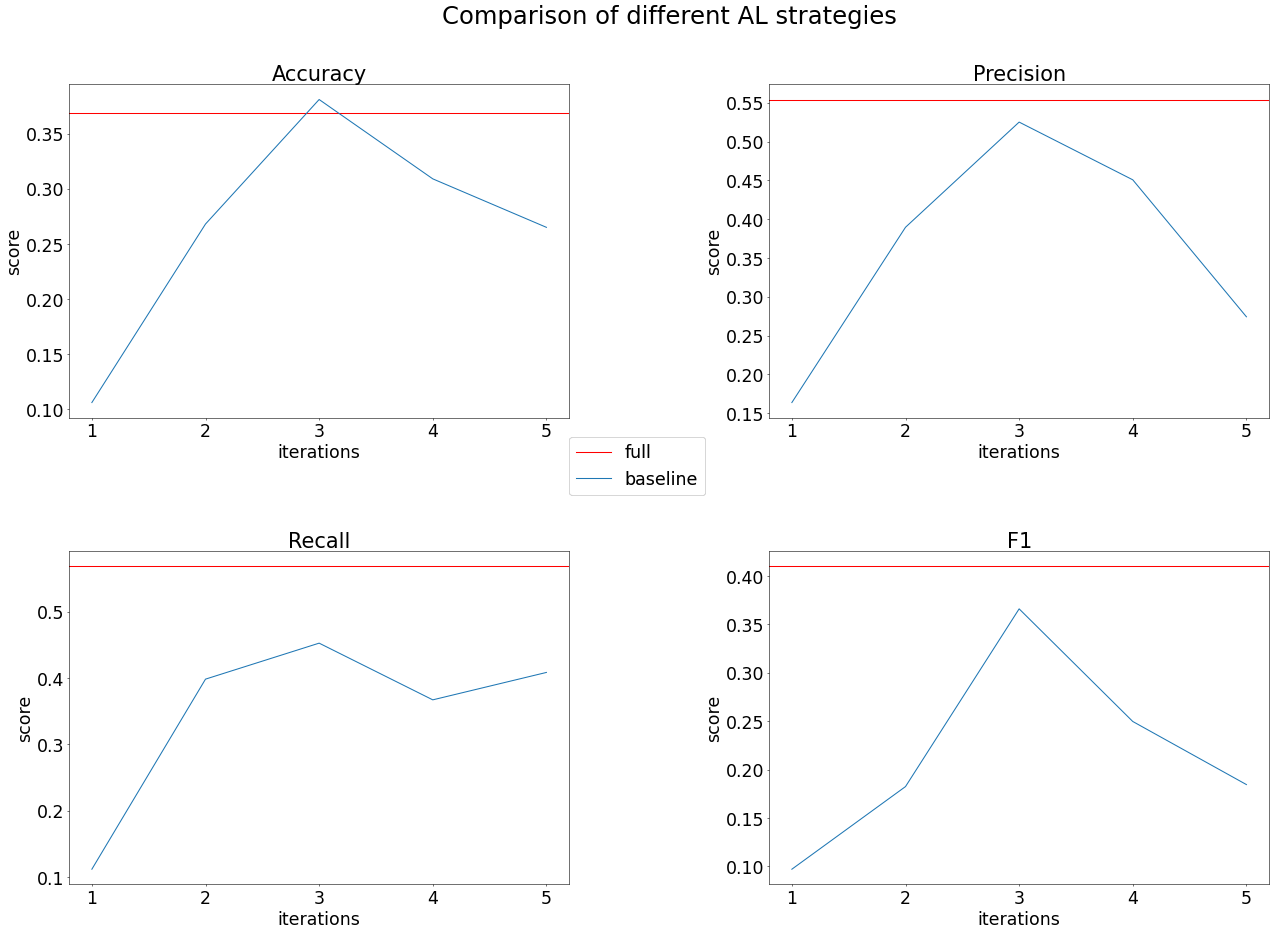

In [14]:


if config['run']['visualise_locally']:
    visualisation = TrainingVisualisation()

if config['run']['full_train']:
    trainer.full_train(
        train_epochs=config['model']['train_epochs'],
        train_batch_size=config['model']['train_batch_size'],
        val_batch_size=config['model']['val_batch_size'],
        test_batch_size=config['model']['test_batch_size'],
        debug=config['app']['debug_mode'],
        save_model_path=str(this_run_folder_path / 'dev_models')
    )

    full_training_metrics = trainer.full_training_metrics
    if config['run']['visualise_locally']:
        visualisation.add_full_training_metrics(full_training_metrics)

strategies = config['run']['strategies']
implemented_strategies_list = list(config['app']['strategies'].keys())
for strategy in strategies:
    if strategy not in implemented_strategies_list:
        logging.warning(f'Strategy {strategy} not found in implemented strategies list: {implemented_strategies_list}. Skipping.')
        continue

    trainer.al_train(
        al_iterations=config['al']['num_iterations'],
        init_dataset_size=config['al']['init_dataset_size'],
        add_dataset_size=config['al']['add_dataset_size'],
        train_epochs=config['model']['train_epochs'],
        strategy=strategy,
        train_batch_size=config['model']['train_batch_size'],
        val_batch_size=config['model']['val_batch_size'],
        test_batch_size=config['model']['test_batch_size'],
        debug=config['app']['debug_mode'],
        save_model_path=str(this_run_folder_path / 'dev_models'),
    )

    al_strategy_metrics = trainer.al_strategy_metrics

    if config['run']['visualise_locally']:
        visualisation.add_al_strategy_metrics(al_strategy_metrics, strategy)

if config['run']['visualise_locally']:
    visualisation.visualise(save_fig_path=config['run']['visualisation_save_path'])


In [ ]:
wandb.finish()

accuracy,▂▂▁▂▃▅▄▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇████████
f1,▁▂▁▂▂▅▅▅▆▆▆▇▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇█████
precision,▂▁▃▅▃▆▆▅▆▅▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████████
recall,▂▂▁▂▃▅▅▆▆▆▇▇▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇███▇█▇▇█▇▇██
test_loss,███▇▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▃▄▃▃▃▃▃▂▃▂▂▂▂▁▁▁▁▁▁▁▁
train_mean_loss,█▇▇▇▇▆▇▆▆▆▆▆▅▅▅▅▅▄▅▄▄▄▄▄▄▃▃▃▂▂▂▂▂▁▂▁▁▂▁▁
accuracy,0.815
f1,0.8068
precision,0.81884
recall,0.815
test_loss,0.87172


### In case if W&B does not synchronize your experiments (it happens to us because they use async calls and their queue is not the most optimal one)

In [ ]:
!wandb sync --project ntu_al --sync-all --include-offline --include-online --include-synced

Syncing: https://wandb.ai/trask/ntu_al/runs/r7cotppm ...done.
Syncing: https://wandb.ai/trask/ntu_al/runs/200hqtpk ...wandb: WARNING .wandb file is incomplete (record checksum is invalid, data may be corrupt), be sure to sync this run again once it's finished
done.
